In [1]:
%%capture
import sys
!pip install category_encoders==2.*
!pip install pandas-profiling==2.*
!pip install pdpbox


In [2]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve, mean_absolute_error
from sklearn.model_selection import train_test_split
from category_encoders import OneHotEncoder, OrdinalEncoder
from pandas_profiling import ProfileReport
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
#change your working directory
%cd /content/gdrive/My Drive/kaggle/catan

Mounted at /content/gdrive
/content/gdrive/My Drive/kaggle/catan


In [4]:
!ls

catanstats.csv


## Wrangle Data

In [5]:
def wrangle(filepath):

  catan = pd.read_csv(filepath,index_col='gameNum')
  # creating a new target variable
  catan['win'] = catan['points'].apply(lambda x: 0 if x <= 9 else 1)
  # dropping the null value columns and unwanted columns
  catan = catan.drop(columns=["me",
        'Unnamed: 18',"Unnamed: 17",	"Unnamed: 19",	"Unnamed: 23", 'Unnamed: 16',
       'Unnamed: 25','points',"Unnamed: 24", 'tradeLoss',"settlement2","settlement1","Unnamed: 26","tribute",	'2','3','4','5','6','7','8','9','10','11','12'])


  return catan
catan = wrangle("catanstats.csv")

In [6]:
# catan.head()
# catan.shape

In [7]:
# catan.isnull().sum()

In [8]:
catan["win"].value_counts(normalize= True)*100

0    75.0
1    25.0
Name: win, dtype: float64

## Split Data

- **Target Attribute** : The target variable should be based on the overall dataset which if the target variable changes all observations and attributes will be changed. depend on the data set I choose is Catan. The Catan game is based on points so into a categorical and see win probability so that why I choose my target variable will be the points attribute.

- **Leakage Feature**: By creating the new target variable (Win) and by taking the old target record and converting it. To avoid leakage we are dropping the old target column (Points).

In [9]:
# Split Target Vector from our Feature Matrix
target = 'win'
X = catan.drop(columns = [target])
y = catan[target]

In [10]:
X.head()

,player,Unnamed: 20,Unnamed: 22,production,tradeGain,robberCardsGain,totalGain,robberCardsLoss,totalLoss,totalAvailable
gameNum,,,,,,,,,,
1,1,C,L,38,5,2,45,2,16,29
1,2,W,L,48,8,6,62,1,20,42
1,3,W,O,44,14,9,67,4,28,39
1,4,L,L,42,12,0,54,6,30,24
2,1,O,W,60,15,16,91,10,38,53


## Training-Validation-Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.14, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.14, random_state=42) 

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(147, 10)
(24, 10)
(147,)
(24,)
(29, 10)
(29,)


## Establish Baseline

- **Accuracy** : The baseline accuracy score will give the percentage win(25%) probability and also help the model prediction. Always classify to the Majority class, in other words, classify according to the prior.



In [12]:
baseline_accuracy  = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy :",baseline_accuracy)

Baseline Accuracy : 0.7482993197278912


## Build Models





- LogisticRegression




In [13]:
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression(max_iter =160,random_state=42))

# fit the model
model_lr.fit(X_train, y_train);

- RandomForestClassifier 

In [14]:
model_rfc = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42)
)

# fit the model
model_rfc.fit(X_train, y_train);

- DecisionTreeClassifier

In [15]:
model_dt = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(),
    DecisionTreeClassifier(random_state=42)
)

# fit the model
model_dt.fit(X_train, y_train);

## GradientBoosting

In [16]:
# YOUR CODE HERE
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier


# pipeline is very similar to RandomForest
model_boost = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    GradientBoostingClassifier(random_state=42)
)

# fit the model
model_boost.fit(X_train, y_train);

## Tuning the Model

- RandomizedSearchCV

In [17]:
from scipy.stats import randint, uniform
clf = make_pipeline(OrdinalEncoder(),
                    SimpleImputer(),
                    RandomForestClassifier(random_state=42)
                    )
param_grid = {
    'simpleimputer__strategy':['mean','median','mode'],
    'randomforestclassifier__max_depth':range(20,150,10),
    'randomforestclassifier__n_estimators':range(20,200,20),


}

model = RandomizedSearchCV(
    clf,
    param_distributions = param_grid,
    n_jobs = -1,
    cv = 7,
    verbose = 40,
    n_iter = 30
)

# fit the model
model.fit(X_train,y_train);

Fitting 7 folds for each of 30 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

## Evaluate Model Performance(Check Matrics)


- Classification Metrics

In [18]:
print('Logestic Regression')
print('model_lr accuracy score for training', accuracy_score(y_train, model_lr.predict(X_train)))
print('model_lr accuracy score for val', accuracy_score(y_val, model_lr.predict(X_val)))

print()
print('Random Forest Classifier')
print("Classification Accuracy:", model_rfc.score(X_train, y_train))
print("Validation Accuracy:", model_rfc.score(X_val, y_val))

print()
print('Decision Tree Classifier')
print('model_dt accuracy score for training', accuracy_score(y_train, model_dt.predict(X_train)))
print('model_dt accuracy score for val', accuracy_score(y_val, model_dt.predict(X_val)))

print()
print('RandomizedSearchCV')
print('Best score for `model`:', model.best_score_)
print('Best params for `model`:', model.best_params_)

print()
print('Boosting Model')
print('Training accuracy:', model_boost.score(X_train, y_train))
print('Validation accuracy:', model_boost.score(X_val, y_val))

Logestic Regression
model_lr accuracy score for training 0.8571428571428571
model_lr accuracy score for val 0.7083333333333334

Random Forest Classifier
Classification Accuracy: 1.0
Validation Accuracy: 0.8333333333333334

Decision Tree Classifier
model_dt accuracy score for training 1.0
model_dt accuracy score for val 0.75

RandomizedSearchCV
Best score for `model`: 0.802721088435374
Best params for `model`: {'simpleimputer__strategy': 'mean', 'randomforestclassifier__n_estimators': 20, 'randomforestclassifier__max_depth': 80}

Boosting Model
Training accuracy: 1.0
Validation accuracy: 0.7916666666666666


## Train-Validation-Test Scores 

In [19]:
# Scores
train_acc = accuracy_score(y_train, model.predict(X_train))
val_acc = accuracy_score(y_val, model.predict(X_val))
test_acc = accuracy_score(y_test, model.predict(X_test))

print('Training Accuracy Score:', train_acc)
print('Validation Accuracy Score:', val_acc)
print('Testing Accuracy Score:', test_acc)

Training Accuracy Score: 1.0
Validation Accuracy Score: 0.75
Testing Accuracy Score: 0.7586206896551724


## ROC Curve

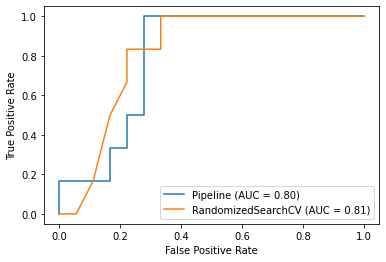

In [20]:
# Plotting ROC Curve for model_lr and model
from sklearn.metrics import recall_score, classification_report, roc_auc_score, plot_roc_curve
fig1 = plot_roc_curve(model_lr, X_val, y_val)
fig2 = plot_roc_curve(model, X_val, y_val, ax = fig1.ax_);



## Permutation Importance

In [21]:
column = 'production'
# It's not that hard to permute (shuffle up the values) a column manually
X_val_perm = X_val.copy()
X_val_perm[column] = np.random.permutation(X_val_perm[column])

In [22]:
perm_imp = permutation_importance(model, X_val, y_val, n_jobs=-1, random_state=42)

In [23]:
perm_imp['importances'][:,0:1].sum()

0.41666666666666663

In [24]:
data = {'imp_mean': perm_imp['importances_mean'],
        'imp_std': perm_imp['importances_std']}

importances = pd.DataFrame(data, index=X_val.columns).sort_values(by='imp_mean', ascending=False)
# importances
importances['imp_mean']

totalAvailable     0.066667
totalGain          0.058333
robberCardsLoss    0.033333
Unnamed: 22        0.016667
player             0.008333
production         0.008333
Unnamed: 20       -0.008333
robberCardsGain   -0.016667
tradeGain         -0.033333
totalLoss         -0.041667
Name: imp_mean, dtype: float64

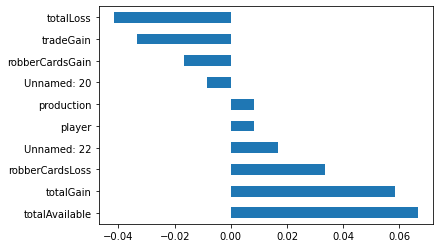

In [25]:
importances['imp_mean'].head(10).plot(kind='barh')

In [26]:
importances['imp_mean'].sum()

0.09166666666666663

### Partial Dependence Plots(PDP)



- With 1 Feature Plot

In [27]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'production'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


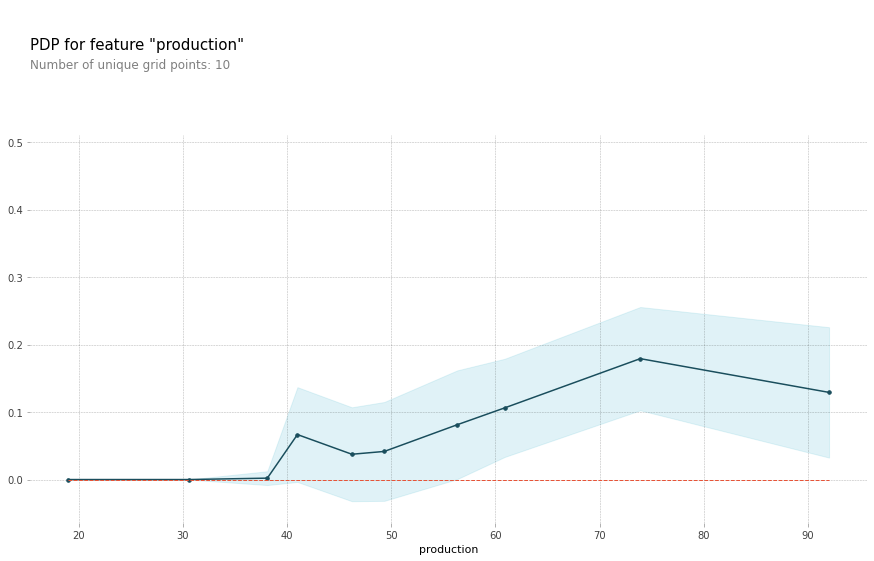

In [28]:
pdp_plot(isolated, feature_name=feature);

- With 2 Features PDP_Interact_Plot

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


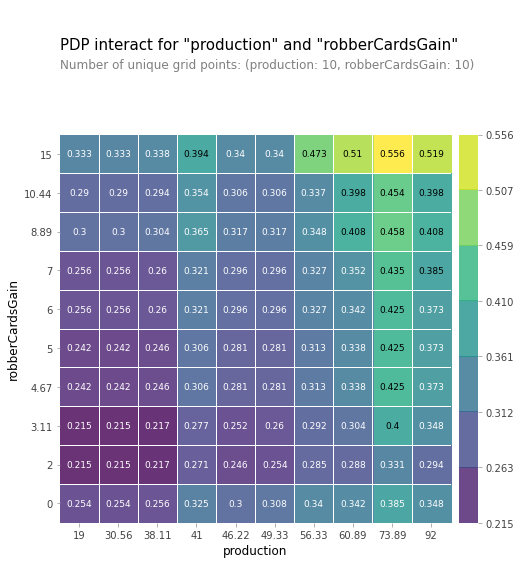

In [29]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['production', 'robberCardsGain']

interaction = pdp_interact(
    model=model, 
    dataset=X_val, 
    model_features=X_val.columns,
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

## Confusion Matrix

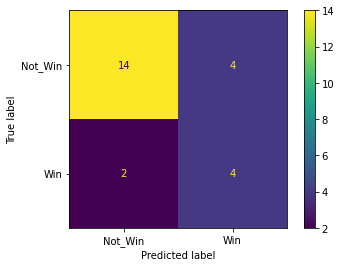

In [30]:
plot_confusion_matrix(
    model,
    X_val, # BE SURE TO USE VALIDATION DATA
    y_val,
    values_format='.0f',
    display_labels=['Not_Win','Win']
);

- True Negative(TN) and True Positive(TP) is 18 out of 24 so it predicted correctly.
- False Negative(FN) and False Positive(FP) are 6 out of 24 so it is misclassified.

## Classification Report

In [31]:
# metrics
from sklearn.metrics import accuracy_score, plot_confusion_matrix, precision_score 
from sklearn.metrics import recall_score, classification_report, roc_auc_score, plot_roc_curve

print(classification_report(y_val, model.predict(X_val)))

              precision    recall  f1-score   support

           0       0.88      0.78      0.82        18
           1       0.50      0.67      0.57         6

    accuracy                           0.75        24
   macro avg       0.69      0.72      0.70        24
weighted avg       0.78      0.75      0.76        24



#                                                   In-Depth Analysis    

 I have a total of 32 attributes in my dataset, and I also omitted the null value column. For the target variable, I chose the points column, and I wanted to check the victory probability, so I converted to binary classification and did the wrangling. My baseline accuracy is flawless (0.74), and for the model, I used three different models: logistic regression, RandomForest, and gradient boosting, with logistic regression training and validation accuracy scores of 0.85 and 0.70, respectively. Next, I used randomized search as a tuning model, and my best score is 0.80, indicating that it is more valuable than logistic regression. The roc curve (AUC = 0.81) also showed this. The confusion matrix shows that TN and TP are accurately predicted, whereas FN and FP are misclassified. According to the classification report,the precision is 0.50 and recall is 0.67.